In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
def calc_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.adj_close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [3]:
def read_data(filename):
    data = pd.read_csv(filename)
    data = data.rename(str.lower, axis=1)
    data = data.rename(mapper={'adj close': 'adj_close'}, axis=1)
    data.date = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

def add_features(df):
    # accumulation/Distribution line
    mult = ((df.close - df.low) - (df.high - df.close)) / (df.high - df.low)
    MFVolume = mult * df.volume
    accum_dist_indicator = MFVolume.cumsum()
    ret_df = pd.concat([df, accum_dist_indicator], axis=1)
    ret_df = ret_df.rename(mapper={0:'accum_dist_indicator'}, axis=1)
    
    #MACD
    EMA_12 = df.adj_close.ewm(span=12, adjust=False).mean()
    EMA_26 = df.adj_close.ewm(span=26, adjust=False).mean()
    macd = EMA_12 - EMA_26
    signal = macd.ewm(span=9, adjust=False).mean()
    ret_df = pd.concat([ret_df, macd.rename('macd'), signal.rename('signal_macd')], axis=1)
    
    #RSI
    rsi = calc_rsi(df)
    ret_df = pd.concat([ret_df, rsi.rename('rsi')], axis=1)
    
    return ret_df
    
def series_to_supervised(data, n_in=1, n_out=1, col_names = [], indicies = [], preds = [], dropnan=True):
    '''
    Convert a time series to a supervised learning dataset
    Args:
        data -> time series to convert as a list or numpy array
        n_in -> number of lag observations as input (X)
        n_out -> number of observations as output (y)
        col_names -> names of the columns
        indicies -> list of the indicies
        preds -> list of column indicies to determine which variables to predict
        dropnan -> flag of whether to drop the rows with NaN
    Returns:
        Pandas DataFrame of series framed for supervised learning
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence
    for i in range(0, n_out):
        cols.append(df[col_names[preds]].shift(-i))
        if i==0:
            names += [('%s(t)' % (col_names[j])) for j in preds]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in preds]
    # putting it together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = indicies
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def scale(train, test):
    '''
    Rescales the train and test sets
    Args:
        train -> numpy array of the training data
        test -> numpy array of the test data
    Returns:
        scaler -> the scaler object for transforming
        train_scaled -> a rescaled version of the train data
        test_scaled -> a rescaled version of the test data
    '''
    # scale train and test to [-1,1]
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def split_data(data, test_percent):
    '''
    Splits the data by percentage amount
    Returns: train, test
    '''
    split_val = int(len(data) * (1 - test_percent))
    train, test = data[:split_val], data[split_val:]
    return train, test

In [4]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:,:-1], train[:,-1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare a model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    for i in range(nb_epoch):
        if not i % 10:
            print('%d/%d' % (i+1, nb_epoch), end='')
        else:
            print('.', end='')
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    print()
    return model

In [5]:
def prep_data(filename, lookback=14):
    # read in the data
    data = read_data(filename)
    # add technical indicators as features
    data = add_features(data)
    # frame as an RNN problem
    data = series_to_supervised(data, lookback, 5, data.columns, data.index, [4])
    # only keep the predictive columns I care about
    data = data.drop(data.columns[-5:-1], axis=1)
    labels = data['adj_close(t+4)'] - data['adj_close(t-1)']
    labels = labels > 0
    labels = labels.astype(float)
    data = data.drop(data.columns[-1], axis=1)
    data = pd.concat([data, labels.rename('labels')], axis=1)
    data_values = data.values
    train, test = split_data(data_values, .2)
    scaler, train_scaled, test_scaled = scale(train[:,:-1], test[:,:-1])
    train_scaled = np.append(train_scaled, train[:,-1].reshape((-1,1)), axis=1)
    test_scaled = np.append(test_scaled, test[:,-1].reshape((-1,1)), axis=1)
    return scaler, train_scaled, test_scaled

In [6]:
#scaler, train, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')
#model = fit_lstm(train, 8, 10, 1)

In [7]:
def evaluate(model, data, batch_size):
    # separate into input, target
    X, y = data[:,:-1], data[:,-1]
    reshaped = X.reshape(X.shape[0], 1, X.shape[1])
    # forecast the data
    output = model.predict(reshaped, batch_size=batch_size, verbose=1)
    classifications = output > np.median(output)
    return precision_score(y, classifications), recall_score(y, classifications), roc_auc_score(y, classifications)

In [8]:
def experiment(repeats, train, test, neurons):
    # run our experiment
    prec_scores, recall_scores, auc_scores = list(), list(), list()
    for r in range(repeats):
        # fit the model
        batch_size = 8
        lstm_model = fit_lstm(train, batch_size, 50, neurons)
        # forecast the training dataset to set state
        train_reshaped = train[:,:-1].reshape(len(train), 1, -1)
        lstm_model.predict(train_reshaped, batch_size=batch_size, verbose=0)
        # now we forecast the test set
        test_trimmed = test[:-(len(test) % 8)]
        prec, rec, auc = evaluate(lstm_model, test_trimmed, batch_size)
        print('%d) Test metrics - prec: %.3f, rec: %.3f, roc_auc: %.3f' %(r+1, prec, rec, auc))
        prec_scores.append(prec)
        recall_scores.append(rec)
        auc_scores.append(auc)
    return prec_scores, recall_scores, auc_scores

1/50.........11/50.........21/50.........31/50.........41/50.........
1) Test metrics - prec: 0.650, rec: 0.454, roc_auc: 0.518
1/50.........11/50.........21/50.........31/50.........41/50.........
2) Test metrics - prec: 0.662, rec: 0.525, roc_auc: 0.533
1/50.........11/50.........21/50.........31/50.........41/50.........
3) Test metrics - prec: 0.647, rec: 0.512, roc_auc: 0.517
1/50.........11/50.........21/50.........31/50.........41/50.........
4) Test metrics - prec: 0.642, rec: 0.509, roc_auc: 0.512
1/50.........11/50.........21/50.........31/50.........41/50.........
5) Test metrics - prec: 0.635, rec: 0.503, roc_auc: 0.504
1/50.........11/50.........21/50.........31/50.........41/50.........
6) Test metrics - prec: 0.636, rec: 0.494, roc_auc: 0.505
1/50.........11/50.........21/50.........31/50.........41/50.........


C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7) Test metrics - prec: 0.000, rec: 0.000, roc_auc: 0.500
1/50.........11/50.........21/50.........31/50.........41/50.........
8) Test metrics - prec: 0.647, rec: 0.512, roc_auc: 0.517
1/50.........11/50.........21/50.........31/50.........41/50.........
9) Test metrics - prec: 0.623, rec: 0.494, roc_auc: 0.491
1/50.........11/50.........21/50.........31/50.........41/50.........
10) Test metrics - prec: 0.638, rec: 0.505, roc_auc: 0.507
1/50.........11/50.........21/50.........31/50.........41/50.........
1) Test metrics - prec: 0.661, rec: 0.524, roc_auc: 0.532
1/50.........11/50.........21/50.........31/50.........41/50.........
2) Test metrics - prec: 0.650, rec: 0.515, roc_auc: 0.520
1/50.........11/50.........21/50.........31/50.........41/50.........
3) Test metrics - prec: 0.639, rec: 0.506, roc_auc: 0.509
1/50.........11/50.........21/50.........31/50.........41/50.........
4) Test metrics - prec: 0.638, rec: 0.505, roc_auc: 0.507
1/50.........11/50.........21/50.........31/5

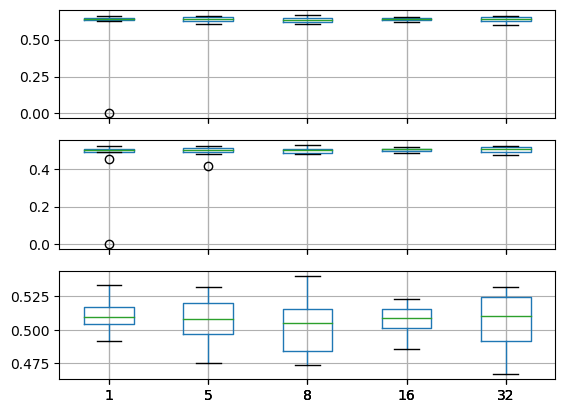

In [9]:
# get our data
_, train, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')
# parameters
repeats = 10
precisions, recalls, aucs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
neurons = [1,5,8,16,32]
for n in neurons:
    precisions[str(n)], recalls[str(n)], aucs[str(n)] = experiment(repeats, train, test, n)
# summarize the results
print(precisions.describe())
print(recalls.describe())
print(aucs.describe())
# save a box plot
fig, ax = plt.subplots(3, 1, sharex=True)
precisions.boxplot(ax=ax[0])
recalls.boxplot(ax=ax[1])
aucs.boxplot(ax=ax[2])
plt.savefig('boxplot_neurons.png')
plt.show()

In [11]:
def experiment(repeats, train, test, epochs):
    # run our experiment
    prec_scores, recall_scores, auc_scores = list(), list(), list()
    for r in range(repeats):
        # fit the model
        batch_size = 16
        train_trimmed = train[len(train)%16:]
        lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 5)
        # forecast the training dataset to set state
        train_reshaped = train_trimmed[:,:-1].reshape(len(train_trimmed), 1, -1)
        lstm_model.predict(train_reshaped, batch_size=batch_size, verbose=0)
        # now we forecast the test set
        test_trimmed = test[:-(len(test) % 16)]
        prec, rec, auc = evaluate(lstm_model, test_trimmed, batch_size)
        print('%d) Test metrics - prec: %.3f, rec: %.3f, roc_auc: %.3f' %(r+1, prec, rec, auc))
        prec_scores.append(prec)
        recall_scores.append(rec)
        auc_scores.append(auc)
    return prec_scores, recall_scores, auc_scores

1/50.........11/50.........21/50.........31/50.........41/50.........
1) Test metrics - prec: 0.639, rec: 0.508, roc_auc: 0.510
1/50.........11/50.........21/50.........31/50.........41/50.........
2) Test metrics - prec: 0.640, rec: 0.509, roc_auc: 0.512
1/50.........11/50.........21/50.........31/50.........41/50.........
3) Test metrics - prec: 0.617, rec: 0.490, roc_auc: 0.487
1/50.........11/50.........21/50.........31/50.........41/50.........
4) Test metrics - prec: 0.622, rec: 0.495, roc_auc: 0.493
1/50.........11/50.........21/50.........31/50.........41/50.........
5) Test metrics - prec: 0.640, rec: 0.509, roc_auc: 0.512
1/50.........11/50.........21/50.........31/50.........41/50.........
6) Test metrics - prec: 0.654, rec: 0.519, roc_auc: 0.526
1/50.........11/50.........21/50.........31/50.........41/50.........
7) Test metrics - prec: 0.637, rec: 0.506, roc_auc: 0.509
1/50.........11/50.........21/50.........31/50.........41/50.........
8) Test metrics - prec: 0.640, rec

1/500.........11/500.........21/500.........31/500.........41/500.........51/500.........61/500.........71/500.........81/500.........91/500.........101/500.........111/500.........121/500.........131/500.........141/500.........151/500.........161/500.........171/500.........181/500.........191/500.........201/500.........211/500.........221/500.........231/500.........241/500.........251/500.........261/500.........271/500.........281/500.........291/500.........301/500.........311/500.........321/500.........331/500.........341/500.........351/500.........361/500.........371/500.........381/500.........391/500.........401/500.........411/500.........421/500.........431/500.........441/500.........451/500.........461/500.........471/500.........481/500.........491/500.........
10) Test metrics - prec: 0.644, rec: 0.512, roc_auc: 0.516
              50        100        250        500
count  10.000000  10.000000  10.000000  10.000000
mean    0.632880   0.622554   0.636277   0.627310
s

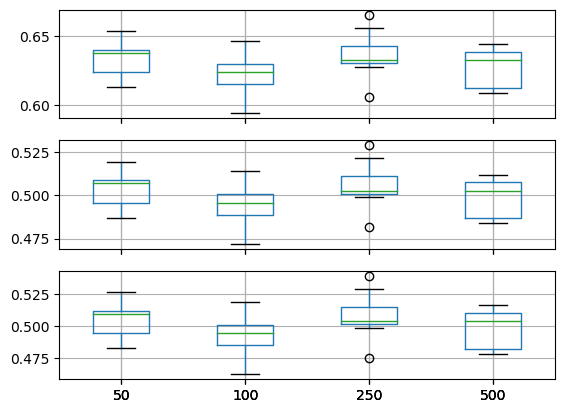

In [12]:
# get our data
_, train, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')
# parameters
repeats = 10
precisions, recalls, aucs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
epochs = [50,100,250,500]
for n in epochs:
    precisions[str(n)], recalls[str(n)], aucs[str(n)] = experiment(repeats, train, test, n)
# summarize the results
print(precisions.describe())
print(recalls.describe())
print(aucs.describe())
# save a box plot
fig, ax = plt.subplots(3, 1, sharex=True)
precisions.boxplot(ax=ax[0])
recalls.boxplot(ax=ax[1])
aucs.boxplot(ax=ax[2])
plt.savefig('boxplot_epochs.png')
plt.show()

In [9]:
def experiment_batch(repeats, train, test, batches):
    # run our experiment
    prec_scores, recall_scores, auc_scores = list(), list(), list()
    for r in range(repeats):
        # fit the model
        batch_size = batches
        train_trimmed = train[len(train)%batch_size:]
        lstm_model = fit_lstm(train_trimmed, batch_size, 100, 5)
        # forecast the training dataset to set state
        train_reshaped = train_trimmed[:,:-1].reshape(len(train_trimmed), 1, -1)
        lstm_model.predict(train_reshaped, batch_size=batch_size, verbose=0)
        # now we forecast the test set
        test_trimmed = test[:-(len(test) % batch_size)] if (len(test)%batch_size) != 0 else test
        prec, rec, auc = evaluate(lstm_model, test_trimmed, batch_size)
        print('%d) Test metrics - prec: %.3f, rec: %.3f, roc_auc: %.3f' %(r+1, prec, rec, auc))
        prec_scores.append(prec)
        recall_scores.append(rec)
        auc_scores.append(auc)
    return prec_scores, recall_scores, auc_scores

1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
741/741 [==============================] - 2s 2ms/step
1) Test metrics - prec: 0.621, rec: 0.491, roc_auc: 0.488
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
741/741 [==============================] - 2s 2ms/step
2) Test metrics - prec: 0.613, rec: 0.456, roc_auc: 0.481
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
741/741 [==============================] - 2s 2ms/step
3) Test metrics - prec: 0.613, rec: 0.485, roc_auc: 0.480
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
741/741 [==============================] - 2s 2ms/step
4) Tes

1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
92/92 [==============================] - 0s 3ms/step
2) Test metrics - prec: 0.639, rec: 0.508, roc_auc: 0.510
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
92/92 [==============================] - 0s 2ms/step
3) Test metrics - prec: 0.609, rec: 0.484, roc_auc: 0.478
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
92/92 [==============================] - 0s 2ms/step
4) Test metrics - prec: 0.630, rec: 0.501, roc_auc: 0.501
1/100.........11/100.........21/100.........31/100.........41/100.........51/100.........61/100.........71/100.........81/100.........91/100.........
92/92 [==============================] - 0s 2ms/step
5) Test metric

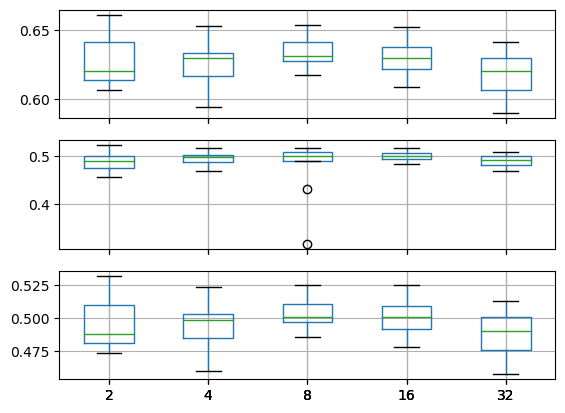

In [10]:
# get our data
_, train, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')
# parameters
repeats = 10
precisions, recalls, aucs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
batches = [2,4,8,16,32]
for n in batches:
    precisions[str(n)], recalls[str(n)], aucs[str(n)] = experiment_batch(repeats, train, test, n)
# summarize the results
print(precisions.describe())
print(recalls.describe())
print(aucs.describe())
# save a box plot
fig, ax = plt.subplots(3, 1, sharex=True)
precisions.boxplot(ax=ax[0])
recalls.boxplot(ax=ax[1])
aucs.boxplot(ax=ax[2])
plt.savefig('boxplot_batches.png')
plt.show()

In [9]:
def experiment_dropout(repeats, train, test, dropout_rate):
    # run our experiment
    prec_scores, recall_scores, auc_scores = list(), list(), list()
    for r in range(repeats):
        # fit the model
        batch_size = 16
        train_trimmed = train[len(train)%batch_size:]
        lstm_model = fit_lstm(train_trimmed, batch_size, 100, 5, dropout=dropout_rate)
        # forecast the training dataset to set state
        train_reshaped = train_trimmed[:,:-1].reshape(len(train_trimmed), 1, -1)
        lstm_model.predict(train_reshaped, batch_size=batch_size, verbose=0)
        # now we forecast the test set
        test_trimmed = test[:-(len(test) % batch_size)] if (len(test)%batch_size) != 0 else test
        prec, rec, auc = evaluate(lstm_model, test_trimmed, batch_size)
        print('%d) Test metrics - prec: %.3f, rec: %.3f, roc_auc: %.3f' %(r+1, prec, rec, auc))
        prec_scores.append(prec)
        recall_scores.append(rec)
        auc_scores.append(auc)
    return prec_scores, recall_scores, auc_scores